In [ ]:
# important libraries
import numpy as np
import pandas as pd
import math
import random
import matplotlib.pyplot as plt


### **1. Construct the training set T = { (x1,y1),(x2,y2),......,(x500,y500)} using the relation Yi = sin(5 π xi) + εi where εi ~ N(0,0.15). Similarly, construct a testing set of size 50 I,e. Test = { (x’1,y’1),(x’2,y’2),......,(x’50,y’50)}. Use RBF kernel in this question for Kernel Regression.**

In [ ]:
# function for compute Root Mean Square Error
def RMSE(Y,predicted_Y):
    rmse = np.sqrt(sum((Y-predicted_Y)**2)/len(Y))
    return rmse

# function for compute Mean Absoulte Error
def MAE(Y,predicted_Y):
    mae = sum(abs(Y - predicted_Y))/len(Y)
    return mae

# function for compute R2 score
def R_2(Y,predicted_Y):
    mean_Y = np.mean(Y)
    mean_est_Y = np.mean(predicted_Y)
    r_2 = sum((Y-mean_Y)**2)/sum((predicted_Y-mean_est_Y)**2)
    return r_2

In [ ]:
#Function to get x and y
def get_x_y( low, high, size, mean, sigma ):
  '''
      low , high : lower and upper limit of interval 
      size : number of data points 
      mean : mean of normally distributed error
      sigma : sigma of normally distributed error
  '''
  x = np.random.uniform(low,high,size)
  e = np.random.normal(mean,sigma,size)
  y = np.sin(5*math.pi*x)+e
  return x , y

In [ ]:
# creating train set
np.random.seed(3)
train_x , train_y = get_x_y( low = 0, high = 1, size = 500,
                             mean = 0, sigma = 0.15 ) 

train = np.array(tuple(zip(train_x,train_y)))



# test set
np.random.seed(15)
test_x,test_y = get_x_y( low = 0, high = 1, size = 50,
                         mean = 0, sigma = 0.15)

test = np.array(tuple(zip(test_x,test_y)))

In [ ]:
# function for get predicted Y
def get_predicted_Y(A,W):   
    return np.matmul(A,W)

#Function for RBF
def RBF(x,z,sigma):
  return math.exp(-(np.linalg.norm(np.array(x)-np.array(z))**2)/(2*(sigma**2)))

#Function for kernel matrix
def kernal_matrix(X1,X2,sigma):
    k = []    #Initialize empty list

    for i in range(len(X1)):
        k.append([])   #Add 1 to sublist 
        for j in range(len(X2)+1):
            k[i].append(1)

    for i in range(len(X1)):
        for j in range(len(X2)):
            #Compute kernel value and assign to sublist element
            k[i][j] = RBF([X1[i]],[X2[j]],sigma)   

    return np.array(k)

In [ ]:
#Function for plotting graph
def plot_graph(train_X,train_Y,test_X,test_Y,predicted_train_Y ,predicted_test_Y ):
    print("*"*50)
    print("Train RMSE is",RMSE(train_Y,predicted_train_Y))
    print("Train MAE is",MAE(train_Y,predicted_train_Y))
    print("Train R^2 is",R_2(train_Y,predicted_train_Y))
    print("*"*50)
    print("Test RMSE is",RMSE(test_Y,predicted_test_Y))
    print("Test MAE is",MAE(test_Y,predicted_test_Y))
    print("Test R^2 is",R_2(test_Y,predicted_test_Y))
    
    plt.scatter(train_X,train_Y, edgecolors='coral',color='white',s=10, alpha=0.5) # scatter plot for training data

    x = np.linspace(0, 1, 10000)

    y = np.sin(5*math.pi*x)   #generate y values for actual curve
    plt.plot(x, y,color='black', label = "Actual Curve")

    X_sorted_index = np.argsort(test_X) 
    X_sorted = test_X[X_sorted_index]            #sort x values for predicted curve
    Y_sorted = predicted_test_Y[X_sorted_index]  # sort predicted y values for predicted curve
    plt.plot(X_sorted,Y_sorted,color='purple', label = "Predicted Curve")

    plt.xlabel('Input X')
    plt.ylabel('Output Y')
    plt.ylim(-2,2)
    plt.legend(loc='best', fontsize='small',facecolor='pink')
    plt.grid()
    plt.show()

##### **a) Estimate the regularized Least Squares Regression using Kernel Regression with Gradient Descent.**

In [ ]:
#Function for gradient of RLF(Regularized Loss Function)
def gradient_of_RLF(Y,K,u,Lembda): 
    u0 = u.copy()
    u0[-1] = 0   #Set last element of u0 to zero to exclude bias term from regularization
    grad = (Lembda*u0 - K.T @ (Y - K @ u)) 
    return grad

In [ ]:
#Function to get u for RLF
def get_u_for_RLF(alpha,K,Y,Lembda,no_iteration=100000): # alpha is learning rate
    u = np.zeros(K.shape[1])    #Initialize u as an array of zeros
    for i in range(no_iteration):
        u = u - alpha * gradient_of_RLF(Y,K,u,Lembda)   #Update u using the gradient of the RLF
    return u

In [ ]:
#Function for getting lembda and sigma
def get_Sigma_and_Lembda_for_best_RMSE_MAE_R2(alpha,X,Y,set_of_sigma,set_of_Lembda):
    #Initialize the optimal metric values to a large number or negative value, respectively
    opti_rmse = 2**10  
    opti_mae = 2**10
    opti_r_2 = 2**10
    opti_sigma = -1
    opti_Lembda = 2**10

    for lem in set_of_Lembda:
        for sigma in set_of_sigma:
            k = kernal_matrix(X,X,sigma)
            u = get_u_for_RLF(alpha,k,Y,lem,no_iteration=100000)
            predicted_y = get_predicted_Y(k,u)
            rmse = RMSE(Y,predicted_y) 
            mae = MAE(Y,predicted_y)   
            r_2 = R_2(Y,predicted_y)
            
            # If the current metric values are better than the previous optimal values, update the optimal values
            if (rmse < opti_rmse) and (mae < opti_mae) and (r_2 < opti_r_2):
                opti_rmse = rmse
                opti_mae = mae
                opti_r_2 = r_2
                opti_sigma = sigma
                opti_Lembda = lem

    return opti_sigma, opti_Lembda

In [ ]:
#Function for Regularized Kernel Regression with Greadient Descent 
def Regularized_Kernal_Regression_with_GD(alpha,train_X,train_Y,test_X,test_Y,Sigma,Lembda,no_iteration):
  train_k = kernal_matrix(train_X,train_X,Sigma)
  test_k = kernal_matrix(test_X,train_X,Sigma)
  u = get_u_for_RLF(alpha,train_k,train_Y,Lembda,no_iteration=100000)
  predicted_train_Y = get_predicted_Y(train_k,u)
  predicted_test_Y = get_predicted_Y(test_k,u)
  plot_graph(train_X,train_Y,test_X,test_Y,predicted_train_Y,predicted_test_Y)
  return predicted_train_Y, predicted_test_Y

In [ ]:
sigma_set = [0.1,0.2,0.3]
lembda_set = [2**-7,2**-1,2**0,2**1,2**7]

In [ ]:
#Getting sigma and lembda from above function
Sigma, Lembda = get_Sigma_and_Lembda_for_best_RMSE_MAE_R2(0.0001,train_x,train_y,sigma_set,lembda_set)

<ipython-input-7-d8b6b5c4da37>:5: RuntimeWarning: overflow encountered in matmul
  grad = (Lembda*u0 - K.T @ (Y - K @ u))
<ipython-input-8-cfbab128cea5>:5: RuntimeWarning: invalid value encountered in subtract
  u = u - alpha * gradient_of_RLF(Y,K,u,Lembda)   #Update u using the gradient of the RLF


In [ ]:
# Hence
Sigma = 0.1
Lembda = 2**-7

**************************************************
Train RMSE is 0.14452835421290838
Train MAE is 0.11738862775832858
Train R^2 is 1.0391063077082046
**************************************************
Test RMSE is 0.16309972741594872
Test MAE is 0.1277254989541059
Test R^2 is 1.0027026213864567


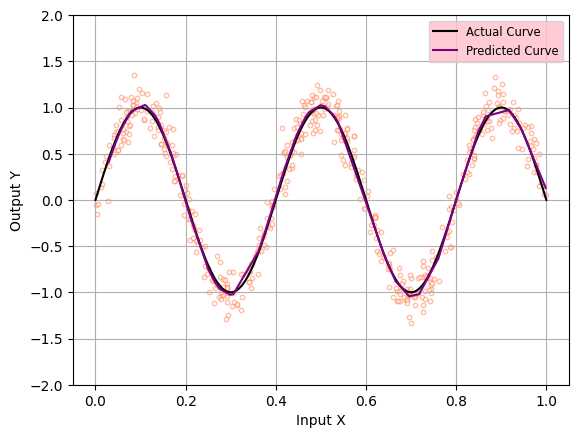

In [ ]:
# RGD means regularized Gradient decent
predicted_train_Y_RGD, predicted_test_Y_RGD = Regularized_Kernal_Regression_with_GD(0.0001,train_x,train_y,test_x,test_y,Sigma,Lembda,1000)

##### **b) Modify the training set T by randomly picking up 5 data points from the training set T and scaling their yi values by 20. Estimate the Least Squares Estimate using Gradient Descent and state your observations.**

In [ ]:
#Gradient of LF(Loss Function)
def gradient_of_LF(Y,K,u):  # LF means Loss Function
    grad = (- K.T @ (Y - K @ u))
    return grad

In [ ]:
#Getting u for loss funnction
def get_u_for_LF(alpha,K,Y,no_iteration=100000): # alpha is learning rate
    u = np.zeros(K.shape[1])  #Initialize u as an array of zeros
    for i in range(no_iteration):
        u = u - alpha * gradient_of_LF(Y,K,u)  #Update u using the gradient of the loss function
    return u

In [ ]:
#Function for Regression with Gradient Descent
def Kernal_Regression_with_GD(alpha,train_X,train_Y,test_X,test_Y,Sigma,no_iteration):
  train_k = kernal_matrix(train_X,train_X,Sigma)
  test_k = kernal_matrix(test_X,train_X,Sigma)
  u = get_u_for_LF(alpha,train_k,train_Y,no_iteration=100000)
  predicted_train_Y = get_predicted_Y(train_k,u)
  predicted_test_Y = get_predicted_Y(test_k,u)
  plot_graph(train_X,train_Y,test_X,test_Y,predicted_train_Y,predicted_test_Y)
  return predicted_train_Y, predicted_test_Y

In [ ]:
np.random.seed(3)
rand_index = np.random.randint(0,500,5)  #Generate a set of 5 random indices

new_train_y = train_y.copy()

#For each randomly selected index, update the corresponding value in new_train_y by multi 20
for idx in rand_index:
    new_train_y[idx] = 20*train_y[idx]

**************************************************
Train RMSE is 0.9139656489075683
Train MAE is 0.23817829483236425
Train R^2 is 2.2901614980967904
**************************************************
Test RMSE is 0.21705313705904375
Test MAE is 0.1605770925503819
Test R^2 is 0.8648303255296939


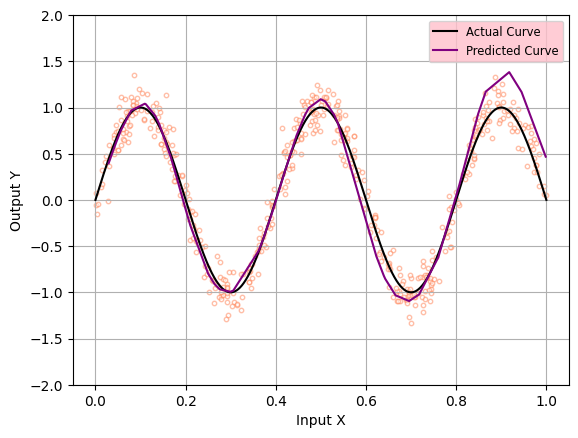

In [ ]:
predicted_train_Y_GD, predicted_test_Y_GD = Kernal_Regression_with_GD(0.0001,train_x,new_train_y,test_x,test_y,Sigma,10000)

##### **c) Modify the optimization problem of the least squares regression model to improve the RMSE results on test data. Further, solve your modified optimization problem using Gradient Descent and calculate the percentage of improvement obtained by your model over the existing least square regression model.**

**************************************************
Train RMSE is 0.913982756863336
Train MAE is 0.23811669930176022
Train R^2 is 2.290443549115438
**************************************************
Test RMSE is 0.21693609631003877
Test MAE is 0.160446746695853
Test R^2 is 0.8650373404196813


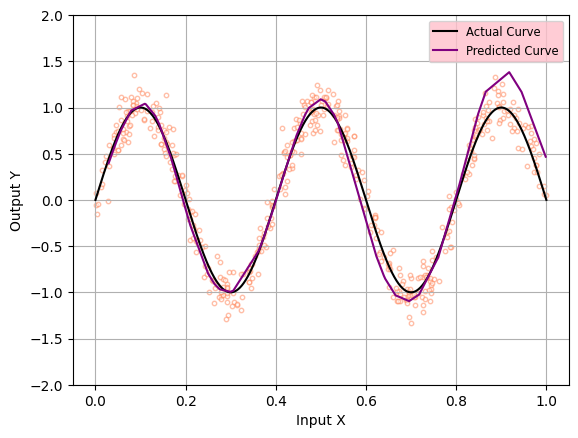

In [ ]:
predicted_train_Y_RGD, predicted_test_Y_RGD = Regularized_Kernal_Regression_with_GD(0.0001,train_x,new_train_y,test_x,test_y,Sigma,Lembda,1000)

In [ ]:
rmse_pre = RMSE(test_y,predicted_test_Y_GD)
rmse_cur = RMSE(test_y,predicted_test_Y_RGD)
perc_of_imp = abs(rmse_cur - rmse_pre)* 100/rmse_pre
print('The percentage of improvement obtained model over the existing least square regression model is',perc_of_imp)

The percentage of improvement obtained model over the existing least square regression model is 0.05392262493453108


In [ ]:
def g(W):  
  g = [0]*len(W)
  for i in range(len(W)-1):
    if W[i] > 0:
      g[i] = 1
    elif W[i] < 0:
      g[i] = -1
    else:
      g[i] = 0
  return np.array(g)

In [ ]:
def subgradient_lasso(Y,A,W,Lembda):  # here vector W contain baised term b
  return (Lembda*g(W) - (1/A.shape[0])*(A.T @ (Y - A @ W)))

In [ ]:
def get_Weights_W_lasso(alpha,A,Y,Lembda,no_iteration=100000): # alpha is learning rate
  W = np.zeros(A.shape[1])
  for i in range(no_iteration):
    W = W - alpha * subgradient_lasso(Y,A,W,Lembda)
  return W

In [ ]:
#Function for Lasso Regression
def Lasso_Regression(alpha,train_X,train_Y,test_X,test_Y,Lembda,Sigma,no_iteration):
  train_k = kernal_matrix(train_X,train_X,Sigma)
  test_k = kernal_matrix(test_X,train_X,Sigma)
  u = get_Weights_W_lasso(alpha,train_k,train_Y,Lembda,no_iteration=100000)
  predicted_train_Y = get_predicted_Y(train_k,u)
  predicted_test_Y = get_predicted_Y(test_k,u)
  plot_graph(train_X,train_Y,test_X,test_Y,predicted_train_Y,predicted_test_Y)
  return predicted_train_Y, predicted_test_Y

**************************************************
Train RMSE is 0.20005362941286775
Train MAE is 0.159318304001216
Train R^2 is 1.3395369176149865
**************************************************
Test RMSE is 0.19657676647579073
Test MAE is 0.15941754207812436
Test R^2 is 1.2668528146600282


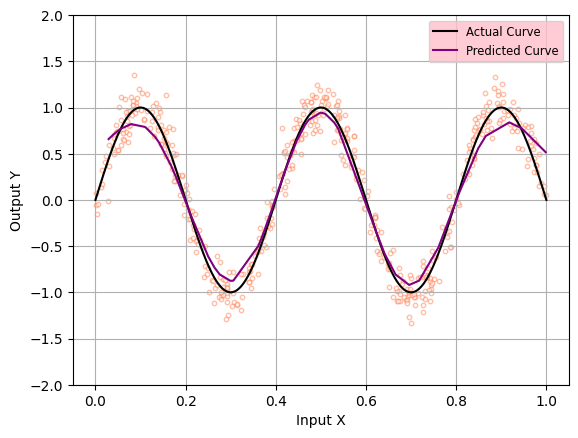

In [ ]:
predicted_train_Y_Lasso, predicted_test_Y_Lasso = Lasso_Regression(0.0001,train_x,train_y,test_x,test_y,Lembda,Sigma,1000)

### **2. Generate the datasets A and B in R2, each consisting of 2000 data points from a normal distribution. The dataset A and B has been drawn from the N (μ1, Σ1 ) and N(μ2, Σ2 ). Let us fix the μ1 = [-1,1] and μ2 = [2,2]. Separate the 250 data points from each class as a testing set.**
**Consider**

**Σ1 = Σ2 = [[2 0],[0 2]]**

In [ ]:
def accuracy(y, y_pred):
  index = np.where(y == 1)

  y_actual_call=y[index]
  y_call=y_pred[index]
  TP=len(np.arange(len(y_actual_call))[y_actual_call==y_call])
  
  index = np.where(y == 0)

  y_actual_call=y[index]
  y_call=y_pred[index]
  TN=len(np.arange(len(y_actual_call))[y_actual_call==y_call])

  index = np.where(y == 1)
  FP=len(y[index][y[index] != y_pred[index]])

  index = np.where(y == 0)
  FN = len(y[index][y[index] != y_pred[index]])

  return (TP + TN) / (TP + TN + FP + FN)

def precision(y, y_pred):
  index = np.where(y == 1)

  y_actual_call=y[index]
  y_call=y_pred[index]
  TP=len(np.arange(len(y_actual_call))[y_actual_call==y_call])

  index = np.where(y == 1)
  FP=len(y[index][y[index] != y_pred[index]])

  return TP / (TP + FP)

def recall(y, y_pred):
  index = np.where(y == 1)

  y_actual_call=y[index]
  y_call=y_pred[index]
  TP=len(np.arange(len(y_actual_call))[y_actual_call==y_call])
  
  index = np.where(y == 0)
  FN = len(y[index][y[index] != y_pred[index]])

  return TP / (TP + FN)

def F1_score(y, y_pred):
  return 2 * precision(y, y_pred) * recall(y, y_pred) / (precision(y, y_pred) + recall(y, y_pred))



#### a). Plot the optimal Bayesian decision boundary for this.

In [ ]:
mu1 = np.array([-1, 1])
mu2 = np.array([2, 2])

sigma1 = np.array([[2,0],[0,2]])
sigma2 = np.array([[2,0],[0,2]])

In [ ]:
np.random.seed(15)
A = np.random.multivariate_normal(mean=mu1, cov=sigma1, size=2000)
B = np.random.multivariate_normal(mean=mu2, cov=sigma2, size=2000)

In [ ]:
# for spliting data
random.seed(42)
split_ratio = 0.875
random.shuffle(A)
split_index = int(A.shape[0] * split_ratio)
train_A = A[:split_index].T
test_A = A[split_index:].T

random.shuffle(B)
train_B = B[:split_index].T
test_B = B[split_index:].T

In [ ]:
'''
    mu1         :  Mean of data A
    mu2         :  Mean of data B
    sigma1      :  cov matrix for data A
    sigma2      :  cov matrix for data B
    p_w1        :  prior probability for data A
    p_w2        :  prior probability for data B
'''


def Bayesian_Classifier(mu1,mu2,sigma1,sigma2,p_w1,p_w2):
    if sigma1[0][1]==sigma1[1][0]==0 and sigma1[0][0]==sigma1[-1][-1] and sigma1.any() == sigma2.any(): # Case 1
        s = sigma1[0][0]
        W = (mu1 - mu2)
        x0 = (1/2)*(mu1 + mu2) - (s*(mu1-mu2)/(np.linalg.norm(mu1-mu2)**2))*np.log(p_w1/p_w2)
    elif sigma1.any() == sigma2.any(): # Case 2
        sigma = sigma1.copy()
        sigma_inv = np.linalg.inv(sigma)
        W = (mu1 - mu2)
        x0 = (1/2)*(mu1 + mu2) - ((mu1 - mu2)/((mu1-mu2).T @ sigma_inv @ (mu1-mu2)))*(np.log(p_w1/p_w2))
    else:
        print('Case 3')
    return W,x0

In [ ]:
'''
    A : data of class 1
    B : data of class 2
    W , X0 : weights
'''

def plot_boundary_by_BC(A,B,W,x0):
    plt.scatter(A[0], A[1], s=15, color='sienna', alpha=0.4, linewidths=0.25, label='x1 class')
    plt.scatter(B[0], B[1], s=15, color='turquoise', alpha=0.4, linewidths=0.25, label='x2 class')
    x = np.linspace(-2,3,10000)
    y = ((W.T @ x0) - (W[0] * x)) / W[1]
    plt.plot(x,y,color = 'black', label='{} * x1 + {} * x2'.format(W[0], W[1]))
    plt.legend(loc='best', fontsize=9)
    plt.title('Bayesian Classification')
    plt.show()

In [ ]:
W,x0 = Bayesian_Classifier(mu1,mu2,sigma1,sigma2,0.5,0.5)

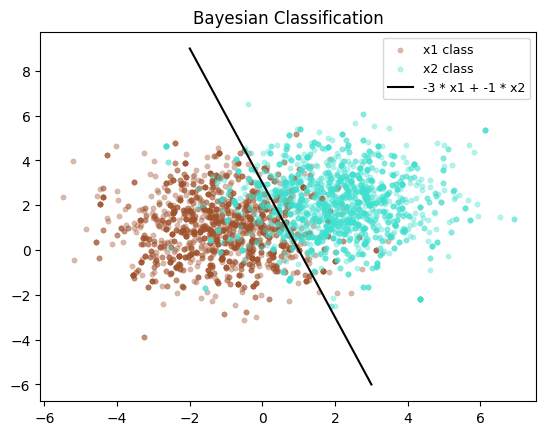

In [ ]:
plot_boundary_by_BC(train_A,train_B,W,x0)

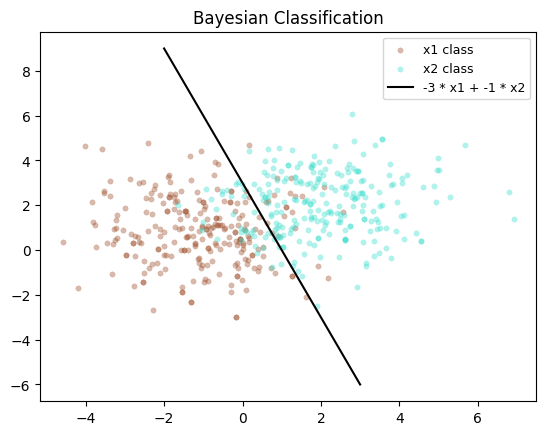

In [ ]:
plot_boundary_by_BC(test_A,test_B,W,x0)

#### B . Train a logistic regression model using the Gradient descent Method and plot the separating decision line.

In [ ]:
def get_X_and_Y(A,B):
    A = np.insert(A,A.shape[0],0,axis=0).T
    B = np.insert(B,B.shape[0],1,axis=0).T
    data = np.concatenate((A,B),axis=0)
    X = data[:,:-1]
    X = np.insert(X,0,1,axis=1)
    Y = data[:,-1]
    index = np.arange(len(Y))
    np.random.shuffle(index)
    X = X[index]
    Y = Y[index]
    return X,Y

In [ ]:
def sigmodial(z):
    return (1 / (1 + np.exp(-z)))

In [ ]:
def logistic_regression(X, Y, alpha, epochs):  # X is matrix of input data and Y is output 
    W = np.zeros(X.shape[1])
    for i in range(epochs):
        z = X @ W
        u = sigmodial(z)
        W = W - (alpha*(X.T @ (u - Y)))
    return W

In [ ]:
def plot_logistic(A,B,W): # only for bivariate data
    plt.figure(figsize=(10,6))
    plt.scatter(A[0], A[1], s=15, color='sienna', alpha=0.4, linewidths=0.25, label='x1 class')
    plt.scatter(B[0], B[1], s=15, color='turquoise', alpha=0.3, linewidths=0.25, label='x2 class')

    x = np.linspace(-3,4,10000)
    y = (-W[1]*x - W[0])/W[2]
    plt.plot(x,y,color='black', label='({}) + ({}) * x1 + ({}) * x2'.format(round(W[0], 2), round(W[1], 2), round(W[2], 2)))
    plt.legend(loc='best', fontsize=6)
    plt.title('Logistic Regression')
    plt.show()

In [ ]:
train_X,train_Y = get_X_and_Y(train_A,train_B)
test_X,test_Y = get_X_and_Y(test_A,test_B)
W_logistic = logistic_regression(train_X, train_Y, 0.01, 22000)

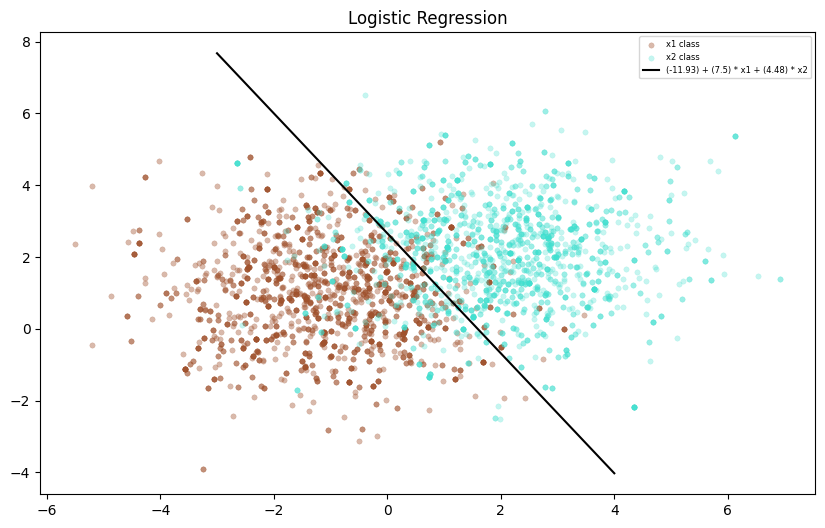

In [ ]:
plot_logistic(train_A,train_B,W_logistic)

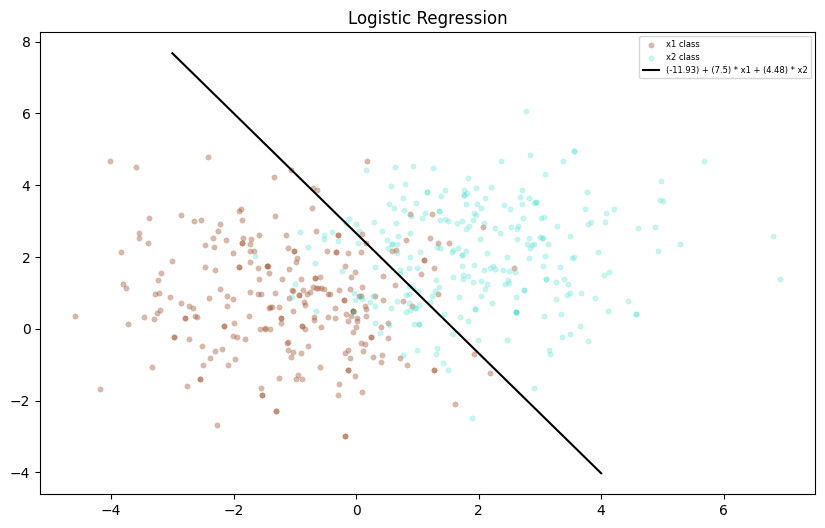

In [ ]:
plot_logistic(test_A,test_B,W_logistic)

#### C . Train the SVM Model Gradient descent Method and plot the separating decision line.

In [ ]:
def get_X_and_Y_SVM(A,B):
    A = np.insert(A,A.shape[0],-1,axis=0).T
    B = np.insert(B,B.shape[0],1,axis=0).T
    data = np.concatenate((A,B),axis=0)
    X = data[:,:-1]
    X = np.insert(X,0,1,axis=1)
    Y = data[:,-1]
    index = np.arange(len(Y))
    np.random.shuffle(index)
    X = X[index]
    Y = Y[index]
    return X,Y

In [ ]:
def g_SVM(X,Y,W):
    g = [0]*X.shape[0]
    Y_hat = (X @ W)
    for i in range(X.shape[0]):
        if (1 - Y[i]*Y_hat[i]) > 0:
            g[i] = -Y[i]
        else:
            g[i] = 0
    g = np.array(g)
    return g.T @ X

In [ ]:
def subgradient_SVM(X,Y,W,C):
  W0 = W.copy()
  W0[-1] = 0
  return W0 + C*g_SVM(Y,X,W)

def get_Weights_W_SVM(alpha,X,Y,C,no_iteration=100000): # alpha is learning rate
    W = np.zeros(X.shape[1])
    for i in range(no_iteration):
        W = W - alpha * subgradient_SVM(Y,X,W,C)
    return W

In [ ]:
def plot_SVM(A,B,W): # only for bivariate data
    plt.scatter(A[0], A[1], s=15, color='sienna', alpha=0.4, linewidths=0.25, label='x1 class')
    plt.scatter(B[0], B[1], s=15, color='turquoise', alpha=0.3, linewidths=0.25, label='x2 class')
    x = np.linspace(-3,3,10000)
    y = (-W[1]*x - W[0]) / W[2]
    z = (1 - W[1]*x - W[0]) / W[2]
    w = (-1 - W[1]*x - W[0]) / W[2]
    plt.plot(x,y,color='black', label='({}) * x0 + ({}) * x1 + ({}) * x2 = 0'.format(round(W[0], 1), round(W[1], 1), round(W[2], 1)))
    plt.plot(x,z,color='black', label='({}) * x0 + ({}) * x1 + ({}) * x2 = 1'.format(round(W[0], 1), round(W[1], 1), round(W[2], 1)), linestyle='--')
    plt.plot(x,w,color='black', label='({}) * x0 + ({}) * x1 + ({}) * x2 = -1'.format(round(W[0], 1), round(W[1], 1), round(W[2], 1)), linestyle='--')
    plt.legend(loc='best', fontsize=6)
    plt.title('SVM')
    plt.show()

In [ ]:
train_X,train_Y = get_X_and_Y_SVM(train_A,train_B)
test_X,test_Y = get_X_and_Y_SVM(test_A,test_B)
W_svm = get_Weights_W_SVM(0.001,train_X,train_Y,0.1,10000)

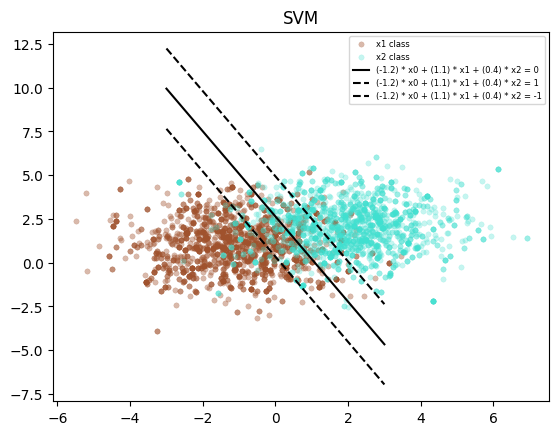

In [ ]:
plot_SVM(train_A,train_B,W_svm)

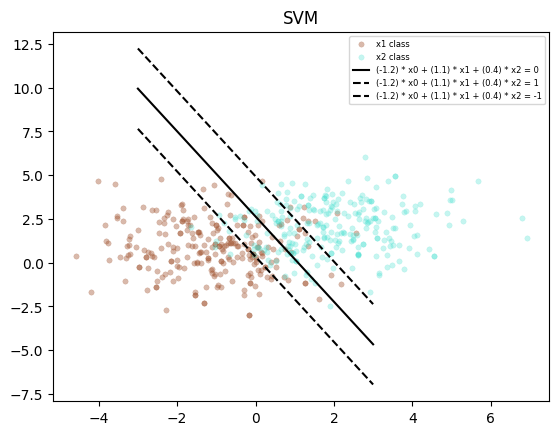

In [ ]:
plot_SVM(test_A,test_B,W_svm)

#### D )  Compare the performance of logistic Regression and SVM using Bayesian Decision Boundary.

In [ ]:
def compare_plot(A,B,W,X0,W2): # only for bivariate data
    plt.scatter(A[0], A[1], s=15, color='sienna', alpha=0.4, linewidths=0.25, label='x1 class')
    plt.scatter(B[0], B[1], s=15, color='turquoise', alpha=0.3, linewidths=0.25, label='x2 class')
    x = np.linspace(-3,3,10000)
    y = ((W.T @ x0) - (W[0] * x)) / W[1]
    z = (-W2[1]*x - W2[0])/W2[2]
    
    plt.plot(x,y,color = 'black', label='Bayesian')
    plt.plot(x,z,color='red', label='SVM')
    plt.legend(loc='best', fontsize=6)
    plt.title('SVM vs Bayesian')
    plt.show()

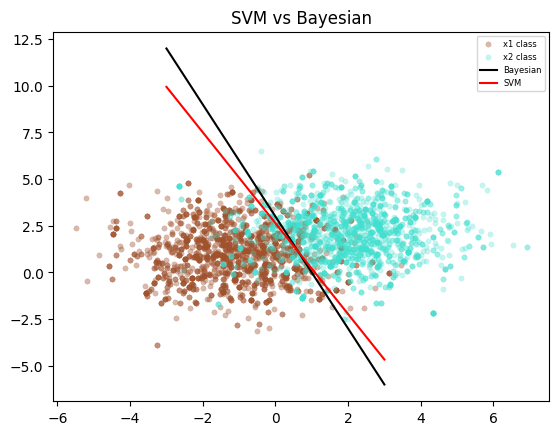

In [ ]:
compare_plot(train_A,train_B , W ,x0, W_svm)

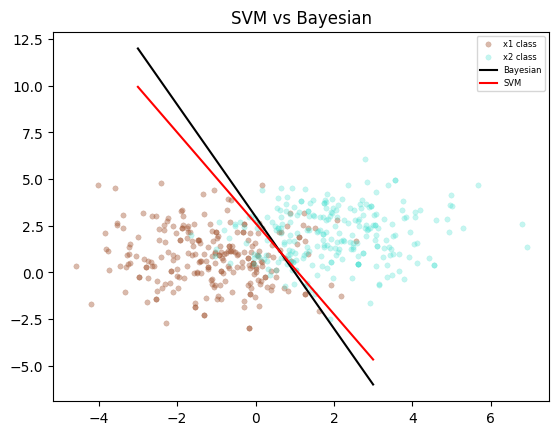

In [ ]:
compare_plot(test_A,test_B , W, x0, W_svm)

In [82]:
def compare_plot2(A,B,W,X0,W2): # only for bivariate data
    plt.scatter(A[0], A[1], s=15, color='sienna', alpha=0.4, linewidths=0.25, label='x1 class')
    plt.scatter(B[0], B[1], s=15, color='turquoise', alpha=0.3, linewidths=0.25, label='x2 class')
    x = np.linspace(-3,3,10000)
    y = ((W.T @ x0) - (W[0] * x)) / W[1]
    z = (-W2[1]*x - W2[0])/W2[2]
    
    plt.plot(x,y,color = 'black', label='Bayesian')
    plt.plot(x,z,color='blue', label='logistic')
    plt.legend(loc='best', fontsize=6)
    plt.title('logistic vs Bayesian')
    plt.show()

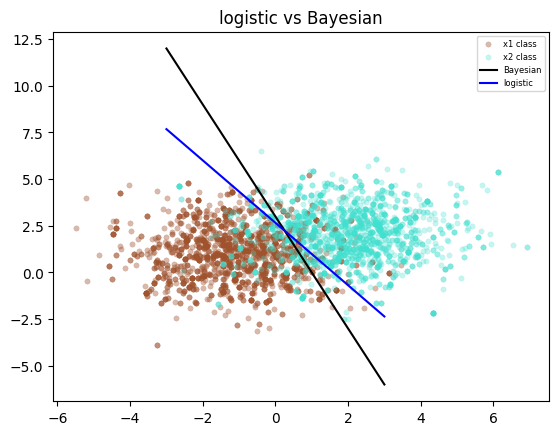

In [83]:
compare_plot2(train_A,train_B,W,x0,W_logistic)

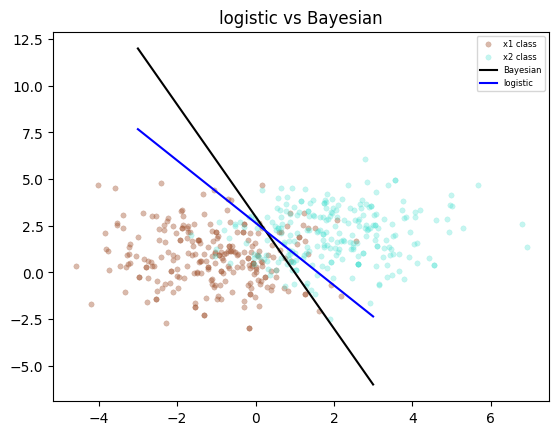

In [84]:
compare_plot2(test_A,test_B,W,x0,W_logistic)

In [85]:
def compare_plot3(A,B,W,X0,W1,W2): # only for bivariate data
    plt.scatter(A[0], A[1], s=15, color='sienna', alpha=0.4, linewidths=0.25, label='x1 class')
    plt.scatter(B[0], B[1], s=15, color='turquoise', alpha=0.3, linewidths=0.25, label='x2 class')
    x = np.linspace(-3,3,10000)
    p = ((W.T @ x0) - (W[0] * x)) / W[1]
    q = (-W1[1]*x - W1[0])/W1[2]
    r = (-W2[1]*x - W2[0])/W2[2]
    plt.plot(x,p,color = 'black', label='Bayesian')
    plt.plot(x,q,color='blue', label='logistic')
    plt.plot(x,r,color='red', label='SVM')
    plt.legend(loc='best', fontsize=6)
    plt.title('logistic vs Bayesian vs SVM')
    plt.show()

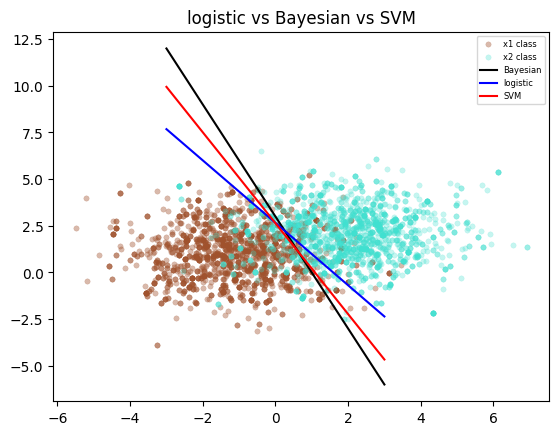

In [86]:
compare_plot3(train_A,train_B,W,x0,W_logistic,W_svm)

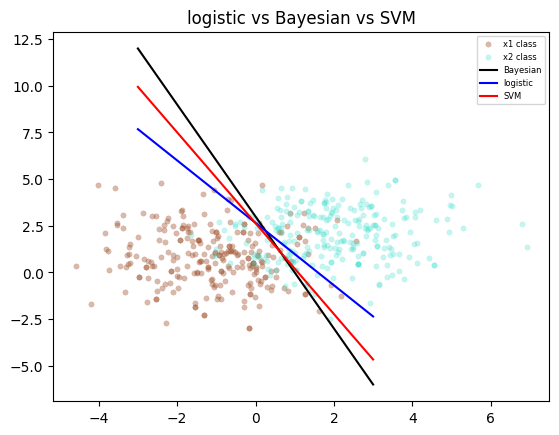

In [87]:
compare_plot3(test_A,test_B,W,x0,W_logistic,W_svm)

### 3). Consider the two-moon dataset. Train Support Vector Machine using the Gradient Descent Method and appropriate Kernel for obtaining the separating surfaces by tuning the parameters. Plot the data points along with separating surfaces. The dataset has been attached in CSV format with this assignment.

In [ ]:
df = pd.DataFrame()
df = pd.read_csv('2moons.csv',header=None,names=['x1','x2','y'])

In [ ]:
train_x = df.iloc[:, :-1].to_numpy()
train_y = df.iloc[:, -1].to_numpy()

In [ ]:
k = kernal_matrix(train_x,train_x,0.25)

In [ ]:
w_svm_kernal = get_Weights_W_SVM(0.01,k,train_y,0.1,1200)

In [ ]:
temp = k @ w_svm_kernal
pred_y = []
for ele in temp:
    if ele < 0:
        pred_y.append(-1)
    else:
        pred_y.append(1)
pred_y = np.array(pred_y)

In [ ]:
accuracy(train_y,pred_y)

1.0